In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import joblib


In [2]:
# Load the preprocessed data 
df = pd.read_csv('../data/processed/processed_data.csv')

# Check basic information about the dataset
print(df.info())

# Check the first few rows of the dataframe
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Longitude              1761 non-null   float64
 1   Latitude               1761 non-null   float64
 2   log_kwh                1761 non-null   float64
 3   log_apartments         1761 non-null   float64
 4   log_kwh_per_apartment  1761 non-null   float64
 5   log_age                1761 non-null   float64
dtypes: float64(6)
memory usage: 82.7 KB
None


,Longitude,Latitude,log_kwh,log_apartments,log_kwh_per_apartment,log_age
0,0.969312,0.656811,-2.011070,0.558041,-1.987314,0.456949
1,1.013363,0.625371,-0.908721,-1.103820,-0.224399,0.958569
2,1.003386,0.626193,-2.646001,-1.870766,-1.447165,0.958569
3,0.994073,0.610885,-0.164134,0.217549,-0.463625,0.155436
4,0.910932,0.560660,-0.100064,0.816927,-0.859612,0.456949


Dataset loaded successfully. Shape: (1761, 6)

Anomaly Summary:
is_anomaly
1    1015
0     746
Name: count, dtype: int64
Total anomalies detected: 1015 out of 1761 records


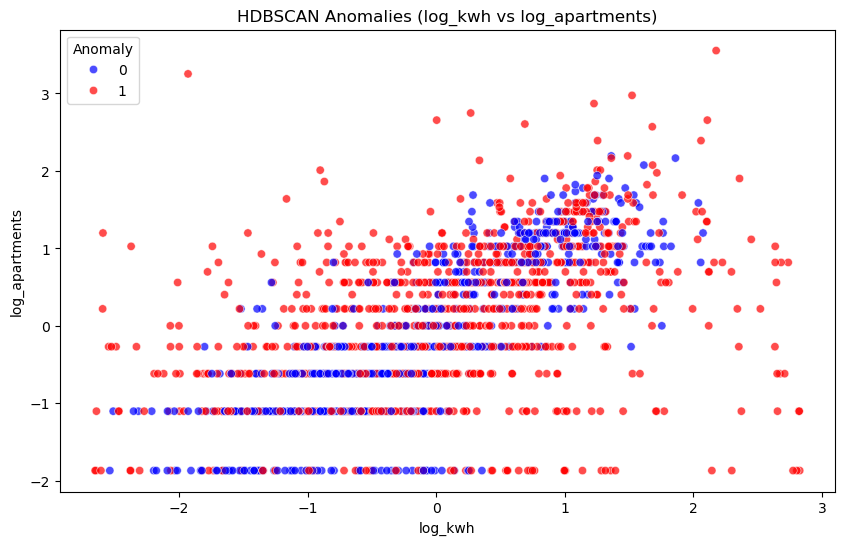

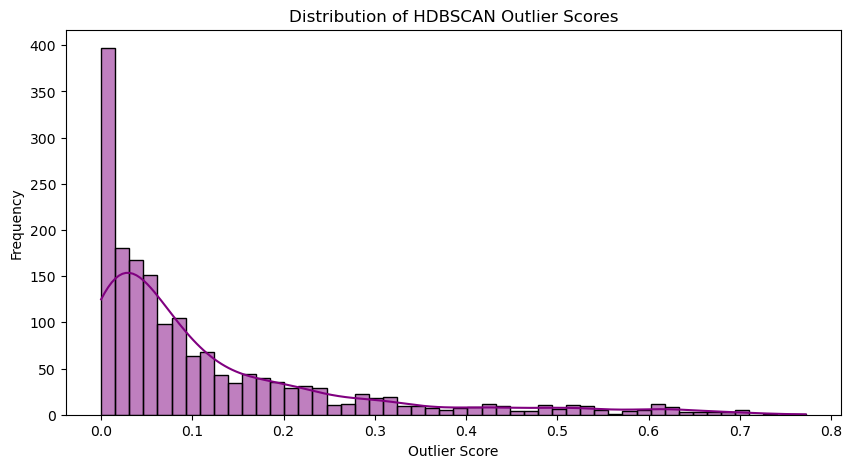


Top 10 Most Anomalous Buildings:
       log_kwh  log_apartments  log_kwh_per_apartment   log_age  Longitude  \
988  -0.098746       -1.870766               1.579796  5.569990   0.699708   
457  -1.930401        3.251675              -2.288787 -5.580443   0.681250   
1480  0.253907       -1.870766               2.073933  0.958569   0.730624   
342  -0.116656       -1.870766               1.555157  0.958569   0.612011   
557  -0.891278       -1.870766               0.532899  0.958569   0.138475   
1467 -2.538650       -1.870766              -1.340400  0.958569   0.725028   
897  -1.466661       -0.271151              -1.357610  0.958569   0.778105   
1133 -0.384228       -1.870766               1.192394  0.958569   1.015730   
1461 -1.745011       -0.619685              -1.383382  0.958569   0.736671   
981  -1.682945       -0.619685              -1.334302  0.958569   0.741308   

      Latitude  outlier_score  
988   1.066873       0.772032  
457  -2.194566       0.737090  
1480 -0.447

'\n# --- Step 10: Save Results ---\ndf.to_csv(\'data/processed/hdbscan_anomalies.csv\', index=False)\nprint("\nAnomaly results saved to: data/processed/hdbscan_anomalies.csv")\n\n'

In [6]:
# ===============================================
#  HDBSCAN Anomaly Detection for Electricity Data
# ===============================================

# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 2: Load Preprocessed Data ---
# Make sure your data file is in data/processed/
df = pd.read_csv('../data/processed/processed_data.csv')
print("Dataset loaded successfully. Shape:", df.shape)

# --- Step 3: Select Relevant Features ---
features = ['log_kwh', 'log_apartments', 'log_kwh_per_apartment', 
            'log_age', 'Longitude', 'Latitude']
X = df[features].copy()

# --- Step 4: Standardize the Features ---
# HDBSCAN is distance-based, so scaling ensures fairness between features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 5: Initialize and Fit HDBSCAN Model ---
# You can tweak min_cluster_size and min_samples to control sensitivity
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, prediction_data=True)
clusterer.fit(X_scaled)

# --- Step 6: Extract Cluster Labels and Anomalies ---
df['cluster_label'] = clusterer.labels_

# HDBSCAN assigns -1 to noise points → treat them as anomalies
df['is_anomaly'] = np.where(df['cluster_label'] == -1, 1, 0)

# HDBSCAN also provides a continuous outlier score (0 = normal, 1 = strong anomaly)
df['outlier_score'] = clusterer.outlier_scores_

print("\nAnomaly Summary:")
print(df['is_anomaly'].value_counts())
print(f"Total anomalies detected: {df['is_anomaly'].sum()} out of {len(df)} records")

# --- Step 7: Visualize Detected Anomalies (2D) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='log_kwh',
    y='log_apartments',
    hue='is_anomaly',
    data=df,
    palette={0: 'blue', 1: 'red'},
    alpha=0.7
)
plt.title('HDBSCAN Anomalies (log_kwh vs log_apartments)')
plt.xlabel('log_kwh')
plt.ylabel('log_apartments')
plt.legend(title='Anomaly', loc='upper left')
plt.show()

# --- Step 8: Visualize Outlier Score Distribution ---
plt.figure(figsize=(10, 5))
sns.histplot(df['outlier_score'], bins=50, kde=True, color='purple')
plt.title('Distribution of HDBSCAN Outlier Scores')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.show()

# --- Step 9: Inspect Top 10 Most Anomalous Buildings ---
print("\nTop 10 Most Anomalous Buildings:")
print(df.sort_values(by='outlier_score', ascending=False)[features + ['outlier_score']].head(10))
'''
# --- Step 10: Save Results ---
df.to_csv('data/processed/hdbscan_anomalies.csv', index=False)
print("\nAnomaly results saved to: data/processed/hdbscan_anomalies.csv")

'''


In [7]:
import hdbscan
import numpy as np
from sklearn.metrics import silhouette_score

param_grid = {
    'min_cluster_size': [10, 20, 30, 50, 80, 100],
    'min_samples': [None, 5, 10, 20, 30],
    'cluster_selection_epsilon': [0.0, 0.1, 0.2],
    'cluster_selection_method': ['eom', 'leaf']
}

results = []

for mcs in param_grid['min_cluster_size']:
    for ms in param_grid['min_samples']:
        for eps in param_grid['cluster_selection_epsilon']:
            for method in param_grid['cluster_selection_method']:
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=mcs,
                    min_samples=ms,
                    cluster_selection_epsilon=eps,
                    cluster_selection_method=method,
                    metric='euclidean'
                ).fit(X_scaled)

                labels = clusterer.labels_
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                noise_ratio = np.sum(labels == -1) / len(labels)

                # Silhouette only if there are >=2 clusters
                sil = silhouette_score(X_scaled, labels) if n_clusters > 1 else np.nan
                mean_prob = clusterer.probabilities_.mean()

                results.append({
                    'min_cluster_size': mcs,
                    'min_samples': ms,
                    'epsilon': eps,
                    'method': method,
                    'n_clusters': n_clusters,
                    'noise_ratio': noise_ratio,
                    'silhouette': sil,
                    'mean_prob': mean_prob
                })

import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values(by=['silhouette', 'mean_prob'], ascending=False).head(10)


,min_cluster_size,min_samples,epsilon,method,n_clusters,noise_ratio,silhouette,mean_prob
156,100,5.0,0.0,eom,2,0.123225,0.262497,0.760967
158,100,5.0,0.1,eom,2,0.123225,0.262497,0.760967
160,100,5.0,0.2,eom,2,0.123225,0.262497,0.760967
126,80,5.0,0.0,eom,2,0.123225,0.262497,0.755327
128,80,5.0,0.1,eom,2,0.123225,0.262497,0.755327
130,80,5.0,0.2,eom,2,0.123225,0.262497,0.755327
132,80,10.0,0.0,eom,2,0.214651,0.224076,0.660407
134,80,10.0,0.1,eom,2,0.214651,0.224076,0.660407
136,80,10.0,0.2,eom,2,0.214651,0.224076,0.660407
102,50,10.0,0.0,eom,2,0.214651,0.224076,0.655596


In [8]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=5,
    cluster_selection_epsilon=0.0,
    cluster_selection_method='eom',
    metric='euclidean'
)
labels = clusterer.fit_predict(X_scaled)


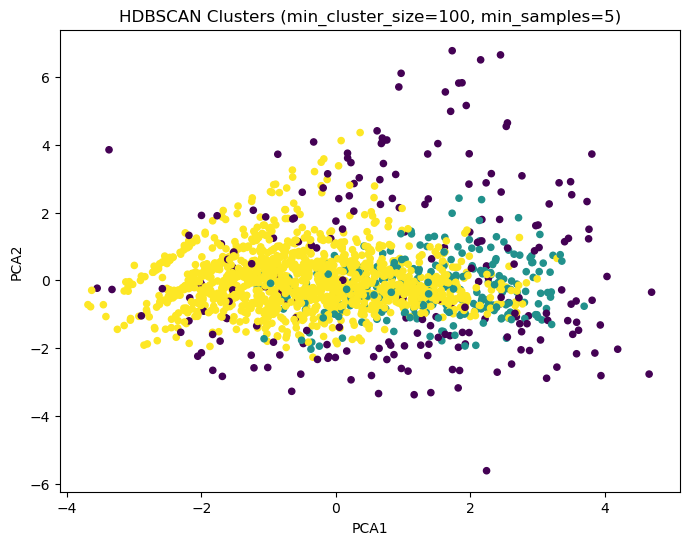

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='viridis', s=20)
plt.title('HDBSCAN Clusters (min_cluster_size=100, min_samples=5)')
plt.xlabel('PCA1'); plt.ylabel('PCA2')
plt.show()


In [10]:
df['cluster'] = labels
df['probability'] = clusterer.probabilities_

# Noise points are anomalies
anomalies = df[df['cluster'] == -1]


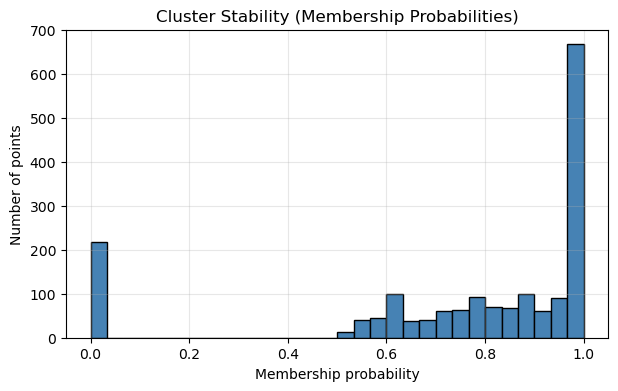

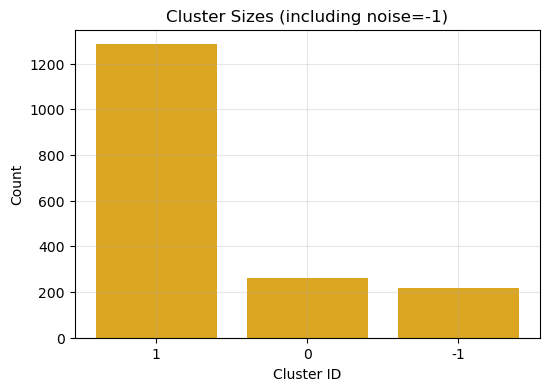

   cluster  count
2        1   1284
1        0    260
0       -1    217


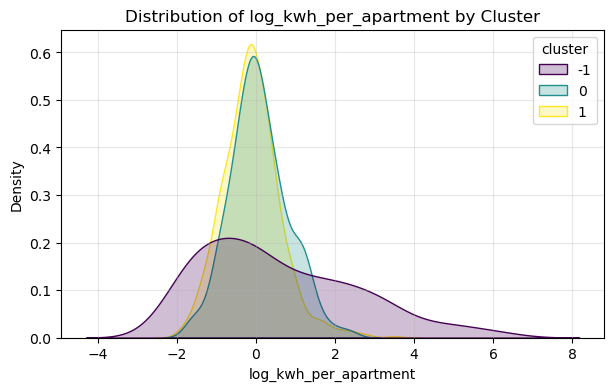

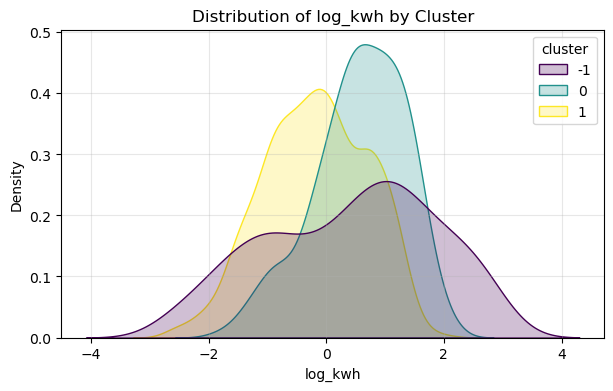

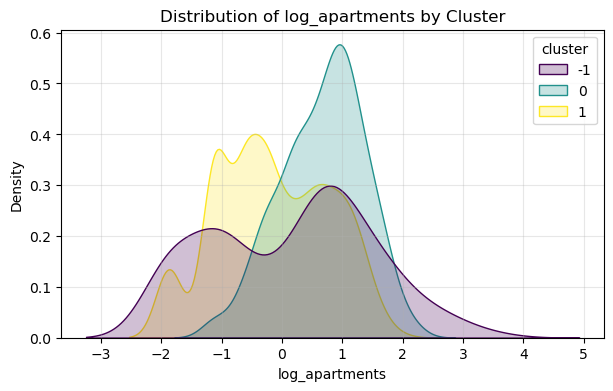

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ---- 1. Cluster stability histogram ----
plt.figure(figsize=(7,4))
plt.hist(clusterer.probabilities_, bins=30, color='steelblue', edgecolor='black')
plt.title("Cluster Stability (Membership Probabilities)")
plt.xlabel("Membership probability")
plt.ylabel("Number of points")
plt.grid(alpha=0.3)
plt.show()

# ---- 2. Cluster size distribution ----
labels = clusterer.labels_
unique, counts = np.unique(labels, return_counts=True)
size_df = pd.DataFrame({'cluster': unique, 'count': counts}).sort_values('count', ascending=False)

plt.figure(figsize=(6,4))
plt.bar(size_df['cluster'].astype(str), size_df['count'], color='goldenrod')
plt.title("Cluster Sizes (including noise=-1)")
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

print(size_df)

# ---- 3. Feature distributions by cluster ----
# You can choose fewer variables if it's too dense
features_to_plot = ['log_kwh_per_apartment', 'log_kwh', 'log_apartments']

for feat in features_to_plot:
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=df, x=feat, hue='cluster', fill=True, common_norm=False, palette='viridis')
    plt.title(f"Distribution of {feat} by Cluster")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.grid(alpha=0.3)
    plt.show()
